In [ ]:
# Ejecutar esta celda antes de las librerías
!pip install chromadb

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import chromadb
from chromadb.config import Settings
import vertexai
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from PIL import Image
from google.cloud import storage
import io
import os
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# **Dataframe de imágenes MHIST desde GCS**

In [ ]:
# Este bloque conecta al bucket de GCS, descarga el archivo de anotaciones y todas las imágenes MHIST,
# convierte las etiquetas a 0/1, filtra por partición (train/test) y arma dos arreglos:
#  • X: todas las imágenes como arrays (N×224×224×3)
#  • y: sus etiquetas binarias (0 o 1)

# 1) Parámetros de tu bucket
BUCKET_NAME    = "datasets_biomed_llm"
PREFIX_IMAGES  = "MHIST/"         # carpeta en el bucket
PREFIX_CSV     = "MHIST/annotations_train_val_test.csv" # ruta dentro del bucket

# 2) Inicializa el cliente de GCS
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

# 3) Descarga y carga el CSV de anotaciones
blob_csv = bucket.blob(PREFIX_CSV)
data_csv = blob_csv.download_as_bytes()
df = pd.read_csv(io.BytesIO(data_csv))

# 4) Procesa la etiqueta binaria
df["y"] = (df["Majority Vote Label"] == "SSA").astype(int)

In [ ]:
df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aaa.png,SSA,6,train,1
1,MHIST_aab.png,HP,0,train,0
2,MHIST_aac.png,SSA,5,train,1
3,MHIST_aae.png,HP,1,train,0
4,MHIST_aaf.png,SSA,5,train,1
...,...,...,...,...,...
3147,MHIST_cpn.png,SSA,7,val,1
3148,MHIST_cfc.png,SSA,7,test,1
3149,MHIST_cgp.png,SSA,7,test,1
3150,MHIST_dlf.png,SSA,7,train,1


In [ ]:
# DataFrame de entrenamiento
train_df = df[df["Partition"] == "train"].reset_index(drop=True)

# DataFrame de validación
val_df = df[df["Partition"] == "val"].reset_index(drop=True)

# DataFrame de prueba
test_df  = df[df["Partition"] == "test"].reset_index(drop=True)

In [ ]:
train_df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aaa.png,SSA,6,train,1
1,MHIST_aab.png,HP,0,train,0
2,MHIST_aac.png,SSA,5,train,1
3,MHIST_aae.png,HP,1,train,0
4,MHIST_aaf.png,SSA,5,train,1
...,...,...,...,...,...
1735,MHIST_bxr.png,SSA,7,train,1
1736,MHIST_bub.png,SSA,7,train,1
1737,MHIST_bvy.png,SSA,7,train,1
1738,MHIST_dlf.png,SSA,7,train,1


In [ ]:
val_df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aai.png,HP,3,val,0
1,MHIST_aam.png,HP,0,val,0
2,MHIST_aas.png,SSA,4,val,1
3,MHIST_aat.png,HP,0,val,0
4,MHIST_aaw.png,HP,0,val,0
...,...,...,...,...,...
430,MHIST_bxq.png,SSA,7,val,1
431,MHIST_cja.png,SSA,7,val,1
432,MHIST_eeh.png,SSA,7,val,1
433,MHIST_bcy.png,SSA,7,val,1


In [ ]:
test_df

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aag.png,HP,2,test,0
1,MHIST_aah.png,HP,2,test,0
2,MHIST_aaq.png,SSA,5,test,1
3,MHIST_aar.png,HP,0,test,0
4,MHIST_aay.png,HP,1,test,0
...,...,...,...,...,...
972,MHIST_eqz.png,SSA,7,test,1
973,MHIST_edm.png,SSA,7,test,1
974,MHIST_blw.png,SSA,7,test,1
975,MHIST_cfc.png,SSA,7,test,1


# **Modelo Multimodal**

## Cálculo de embeddings para una única imagen MHIST (NO VOLVER A EJECUTAR)

In [ ]:
# Descripción:
# Este bloque toma la primera imagen del array X, la guarda temporalmente,
# la carga con Vertex AI y obtiene sus vectores de embedding (imagen y texto)
# usando el modelo multimodal preentrenado.

from vertexai.preview.vision_models import Image as VertexImage
from PIL import Image as PILImage

embedding_dimension = 128
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

# 1) Selecciona la primera imagen de tu array X
pil_img = PILImage.fromarray(X[0])

# 2) Guárdala temporalmente en disco
tmp_path = "/tmp/mhist_single.png"
pil_img.save(tmp_path)

# 3) Cárgala como VertexImage
vm_image = VertexImage.load_from_file(tmp_path)

# 4) Obtén los embeddings para esa única imagen
embeddings = model.get_embeddings(
    image=vm_image,
    contextual_text="Colorectal polyp histology image",
    dimension=embedding_dimension,
)

# 5) Imprime los resultados
print(f"Image Embedding: {embeddings.image_embedding}")
print(f"Text Embedding:  {embeddings.text_embedding}")


Image Embedding: [0.0581890754, -0.0886264443, -0.033333119, 0.017730996, -0.478074551, -0.0970753133, -0.0709414259, 0.0845462084, 0.0148788709, 0.0573178269, 0.00807760283, 0.0112332422, -0.0207296219, 0.0160083, 0.0252900273, 0.114717, 0.0735298246, -0.0082996292, -0.00696632871, 0.00283077033, -0.00408642413, 0.00265225931, 0.0235788096, -0.0196246859, -0.0337747857, -0.0528677069, 0.000480756396, 0.24559994, -0.0462351963, 0.0133150481, 0.0315726809, 0.0792106166, -0.053355068, 0.0274587721, 0.0125244251, 0.0358757563, 0.00512137217, 0.149138048, -0.0432135724, 0.0275929198, -0.0216618571, 0.0092702955, -0.00316974893, -0.0426132865, 0.0481336862, 0.0489111692, -0.0402154, -0.0245273858, -0.0291484483, -0.0152440146, 0.00376179488, -0.0198095869, -0.0506469049, -0.0381370448, -0.0987074077, -0.0340859182, 0.0327998549, 0.0792987496, -0.0715342835, -0.0380299054, -0.0310945809, 0.0358647, -0.0263526067, -0.00872981921, -0.0101693422, 0.03939813, -0.0835158229, -0.0529049933, 0.0182

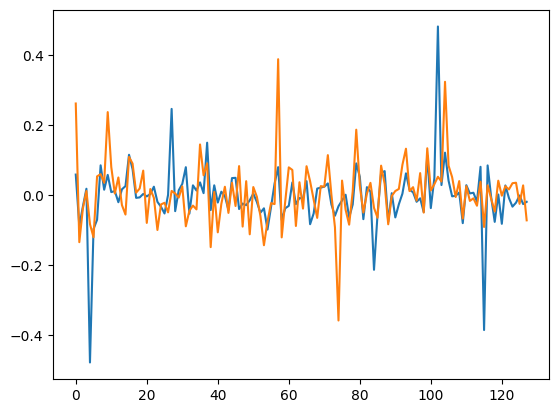

In [ ]:
plt.plot(embeddings.image_embedding)
plt.plot(embeddings.text_embedding)
plt.show()

## Función para obtener embeddings de MHIST desde GCS con el modelo multimodal

In [ ]:
# Descripción:
# Esta función recorre un DataFrame de imágenes de prueba o entrenamiento,
# descarga cada archivo desde el bucket, lo convierte en embedding con el modelo
# multimodal y devuelve tres arreglos: índices, embeddings y etiquetas.
# IMPORTANTE AQUÍ EL EMBEDDING TEXTUAL SE PIERDE.

# prompt: Create a function that receives a df and returns
# the embeddings of the images and the label as a two np.arrays

def process_mhist_df(df, bucket, prefix):
    """
    Dado un DataFrame `df` con columnas:
      - "Image Name" (nombre de archivo, p. ej. "g0001.jpg")
      - "y"          (etiqueta binaria)
    y un bucket de GCS con prefijo `prefix`,
    descarga cada imagen, obtiene su embedding y etiqueta,
    y devuelve:
      - indices:    lista de índices del DataFrame
      - embeddings: np.array de shape (N, embedding_dimension)
      - labels:     np.array de shape (N,)
    """
    indices = []
    embeddings = []
    labels = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        indices.append(idx)
        labels.append(row["y"])

        # Descarga imagen desde GCS
        img_blob = bucket.blob(prefix + row["Image Name"])
        img_bytes = img_blob.download_as_bytes()

        # Carga y preprocesa con PIL
        pil_img = (
            PILImage.open(io.BytesIO(img_bytes))
                    .convert("RGB")
                    .resize((224, 224))
        )

        # Guarda temporal y envuélvelo para Vertex AI
        tmp_path = f"/tmp/{row['Image Name']}"
        pil_img.save(tmp_path)
        vm_image = VertexImage.load_from_file(tmp_path)

        # Obtén embedding
        emb = model.get_embeddings(
            image=vm_image,
            contextual_text="Colorectal polyp histology image",
            dimension=embedding_dimension,
        )
        embeddings.append(emb.image_embedding)

    return indices, np.array(embeddings), np.array(labels)

## Obtención de embeddings para el conjunto de prueba y entrenamiento de MHIST con el modelo multimodal
(**Tarda alrededor de 9 minutos en test y 19 minutos en train**)

In [ ]:
# EJECUTAR ESTA CELDA
# Descripción:
# Este bloque descarga las imágenes de prueba desde el bucket,
# las convierte en embeddings con el modelo multimodal
# y devuelve los arreglos de embeddings y sus etiquetas asociadas.
# se aplica la función process_mhist_df definida y descrita arriba

_, test_embeddings, test_labels = process_mhist_df(
    test_df,
    bucket,
    PREFIX_IMAGES
)

print(f"Obtenidos {len(test_embeddings)} embeddings de test")

100%|██████████| 977/977 [08:48<00:00,  1.85it/s]

Obtenidos 977 embeddings de test


In [ ]:
# EJECUTAR ESTA CELDA
# Descripción:
# Este bloque descarga las imágenes de entrenamiento desde el bucket,
# las convierte en embeddings con el modelo multimodal
# y devuelve los arreglos de embeddings y sus etiquetas asociadas.
# se aplica la función process_mhist_df definida y descrita arriba
# Procesa train desde GCS
_, train_embeddings, train_labels = process_mhist_df(
    train_df,
    bucket,
    PREFIX_IMAGES
)

print(f"Obtenidos {len(train_embeddings)} embeddings de train")

100%|██████████| 2175/2175 [19:07<00:00,  1.90it/s]

Obtenidos 2175 embeddings de train


## Función para calcular métricas de clasificación

In [ ]:
# Descripción:
# Esta celda define una función que recibe etiquetas verdaderas y predichas,
# calcula accuracy, precision, recall, F1 y muestra además el reporte de clasificación
# y la matriz de confusión. Devuelve un diccionario con los valores numéricos de cada métrica.

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

def calculate_metrics(y_true, y_pred, average="binary", display_report=True):
    """
    Calcula métricas de desempeño para clasificación.

    Args:
      y_true (array-like): Etiquetas verdaderas.
      y_pred (array-like): Etiquetas predichas.
      average (str): Método de promedio para precision/recall/F1 en multiclase.
                     Puede ser 'binary', 'micro', 'macro', 'weighted' o None.
      display_report (bool): Si True, imprime classification_report y confusion_matrix.

    Returns:
      dict: {
        "accuracy": float,
        "precision": float,
        "recall": float,
        "f1": float,
        "confusion_matrix": np.ndarray (2D)
      }
    """
    # Cálculo de métricas
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec   = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1    = f1_score(y_true, y_pred, average=average, zero_division=0)
    cm    = confusion_matrix(y_true, y_pred)

    if display_report:
        print("=== Classification Report ===")
        print(classification_report(y_true, y_pred, zero_division=0))
        print("=== Confusion Matrix ===")
        print(cm)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm
    }


## Ingestión (almacenamiento) de embeddings de entrenamiento MHIST en ChromaDB
(**Este proceso no tarda nada**)

In [ ]:
# 1) Setup Chroma client and collection
client = chromadb.Client()

In [ ]:
# Descripción:
# Esta celda crea o limpia la colección en ChromaDB y almacena
# directamente los embeddings de entrenamiento ya calculados
# (junto con sus IDs y etiquetas) para poder hacer búsquedas
# y KNN aproximado sin volver a procesar las imágenes.

from vertexai.preview.vision_models import Image as VertexImage
from PIL import Image as PILImage

embedding_dimension = 128
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")


# Borra la colección si existe (ignora el error si no existe)
try:
    client.delete_collection(name="mhist_image_embeddings")
except Exception:
    pass
collection = client.get_or_create_collection(
    name="mhist_image_embeddings",
    metadata={
        "hnsw:space": "cosine",
        "hnsw:search_ef": 500
    }
)

# 2) GCS bucket params (ya inicializados antes)
# storage_client = storage.Client()
# bucket         = storage_client.bucket(BUCKET_NAME)
# PREFIX_IMAGES  = "MHIST/"

# 3) Recorre solo la partición de train en tu DataFrame df
# for _, row in tqdm(df[df["Partition"]=="train"].iterrows(), total=(df["Partition"]=="train").sum()):
#     img_name = row["Image Name"]
#     try:
#         # 1) descarga bytes
#         img_bytes = bucket.blob(PREFIX_IMAGES + img_name).download_as_bytes()
#         if not img_bytes:
#             raise ValueError("blob vacío")

#         # 2) intenta abrir como PIL
#         pil_img = (
#             PILImage.open(io.BytesIO(img_bytes))
#                     .convert("RGB")
#                     .resize((224, 224))
#         )
#     except Exception as e:
#         print(f"[SKIP] no pude cargar {img_name}: {e}")
#         continue

#     # 3) guarda + envuelve
#     tmp_path = f"/tmp/{img_name}"
#     pil_img.save(tmp_path)
#     vm_image = VertexImage.load_from_file(tmp_path)

#     try:
#         # 4) embedding
#         emb = model.get_embeddings(
#             image=vm_image,
#             contextual_text="Colorectal polyp histology image",
#             dimension=embedding_dimension,
#         )
#     except Exception as e:
#         print(f"[SKIP] error al incrustar {img_name}: {e}")
#         continue

#     # 5) añade a ChromaDB
#     collection.add(
#         ids=[img_name],
#         embeddings=[emb.image_embedding],
#         metadatas=[{"label": int(row["y"])}]
#     )

train_ids = train_df["Image Name"].tolist()

collection.add(
    ids       = train_ids,
    embeddings= train_embeddings,
    metadatas = [{"label": int(l)} for l in train_labels]
)


## Búsqueda de imágenes similares en ChromaDB

In [ ]:
# EJECUTAR ESTA CELDA
# Agregando los indices originales del dataframe df en el dataframe test_df
test_df = (
    df[df["Partition"] == "test"]
      .reset_index()              # el índice viejo pasa a columna “index”
      .rename(columns={"index": "orig_idx"})
)

test_df

,orig_idx,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,5,MHIST_aag.png,HP,2,test,0
1,6,MHIST_aah.png,HP,2,test,0
2,14,MHIST_aaq.png,SSA,5,test,1
3,15,MHIST_aar.png,HP,0,test,0
4,22,MHIST_aay.png,HP,1,test,0
...,...,...,...,...,...,...
972,3134,MHIST_eqz.png,SSA,7,test,1
973,3140,MHIST_edm.png,SSA,7,test,1
974,3142,MHIST_blw.png,SSA,7,test,1
975,3148,MHIST_cfc.png,SSA,7,test,1


In [ ]:
# NO EJECUTAR ESTA CELDA
# Descripción:
# Este bloque toma una imagen de prueba, la descarga del bucket,
# la convierte en embedding con el modelo multimodal y luego
# consulta en ChromaDB las 5 imágenes más parecidas.

# 1) Elige la imagen de consulta (por ejemplo la primera de test)
test_idx = test_df['orig_idx'][0]
img_name = df.loc[test_idx, "Image Name"]

# 2) Descarga la imagen desde GCS
img_blob  = bucket.blob(PREFIX_IMAGES + img_name)
img_bytes = img_blob.download_as_bytes()

# 3) Preprocesa y guarda temporalmente
pil_img = (
    PILImage.open(io.BytesIO(img_bytes))
            .convert("RGB")
            .resize((224, 224))
)
tmp_path = f"/tmp/{img_name}"
pil_img.save(tmp_path)

# 4) Carga con VertexImage
query_vm_image = VertexImage.load_from_file(tmp_path)

# 5) Calcula el embedding de la consulta
query_embedding = model.get_embeddings(
    image=query_vm_image,
    contextual_text="Colorectal polyp histology image",
    dimension=embedding_dimension,
)

# 6) Realiza la búsqueda en ChromaDB
results = collection.query(
    query_embeddings=[query_embedding.image_embedding],
    n_results=5,
)

print(f"Query image: {img_name}")
print("Top-5 resultados similares:")
for res_id, score in zip(results["ids"][0], results["distances"][0]):
    print(f"  {res_id} (distance: {score:.4f})")

Query image: MHIST_aag.png
Top-5 resultados similares:
  MHIST_bcq.png (distance: 0.0104)
  MHIST_ebd.png (distance: 0.0106)
  MHIST_asq.png (distance: 0.0108)
  MHIST_btv.png (distance: 0.0117)
  MHIST_cbt.png (distance: 0.0118)


In [ ]:
# NO EJECUTAR ESTA CELDA
# collection es una colección de vectores en ChromaDB pero de entrenamiento (definido arriba)
# Recuperas el “vector” de la imagen y la info extra que guardaste junto a ella.
collection.get(ids=["MHIST_aae.png"],include=["embeddings", "metadatas"])

{'ids': ['MHIST_aae.png'],
 'embeddings': array([[ 6.04500994e-02, -7.05754757e-02, -4.74731103e-02,
          3.19108628e-02, -4.99059677e-01, -7.52767697e-02,
         -6.57956079e-02,  3.35012749e-02,  1.42764337e-02,
          8.26285928e-02,  8.75613187e-03,  3.69574018e-02,
          1.00431184e-03,  2.95205228e-02,  7.41653237e-03,
          1.46886393e-01,  3.74550000e-02, -9.28886235e-03,
          1.42126000e-02,  1.73302367e-02,  4.45863279e-03,
         -2.87115830e-03,  2.32072473e-02,  8.12557805e-03,
         -2.70434748e-02, -5.20998910e-02,  1.41250258e-02,
          2.36609355e-01, -3.27654630e-02,  1.17373411e-02,
          8.30606222e-02,  8.41432512e-02, -3.21831144e-02,
          2.33039483e-02, -2.60739762e-04,  3.35613415e-02,
         -1.30843008e-02,  1.78135633e-01, -6.63659573e-02,
          4.32970896e-02, -6.84540602e-04, -9.51252878e-03,
         -4.73288214e-03, -3.84356305e-02,  4.08208370e-02,
          7.68692698e-03, -2.37903520e-02, -3.30251493e-02,

## Función genérica KNN para clasificar embeddings basada en ChromaDB

In [ ]:
# Descripción:
# Esta función recibe un conjunto de embeddings y un valor k,
# busca en ChromaDB los k vecinos más cercanos para cada embedding
# y asigna la etiqueta por mayoría de votos entre esos vecinos.

def knn_classification(embeddings, k):
    """
    Esta función clasifica imágenes de prueba usando KNN:
    para cada embedding de prueba busca los k vectores más
    parecidos en la base ChromaDB y asigna la etiqueta que
    más veces aparece entre esos vecinos.

    Args:
      embeddings: np.array con los embeddings de las imágenes de prueba.
      k: Número de vecinos a considerar.

    Returns:
      np.array con la etiqueta predicha para cada embedding de prueba.
    """
    predictions = []
    for emb in tqdm(embeddings, desc="KNN classification"):
        # Busca los k vecinos más cercanos en la colección
        results = collection.query(
            query_embeddings=[emb],
            n_results=k,
            include=["metadatas"]
        )
        # Extrae las etiquetas de los metadatos de cada vecino
        neighbor_labels = [
            md["label"]
            for result in results["metadatas"]
            for md in result
        ]
        # Votación mayoritaria
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predictions.append(unique_labels[np.argmax(counts)])
    return np.array(predictions)


## Predicciones sobre el conjunto de test

In [ ]:
test_pred = knn_classification(test_embeddings, 20)

KNN classification: 100%|██████████| 977/977 [00:02<00:00, 335.96it/s]


## Evaluación de métricas

In [ ]:
calculate_metrics(test_labels, test_pred, average="binary")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       617
           1       0.69      0.56      0.62       360

    accuracy                           0.75       977
   macro avg       0.73      0.71      0.71       977
weighted avg       0.74      0.75      0.74       977

=== Confusion Matrix ===
[[528  89]
 [159 201]]


{'accuracy': 0.7461617195496417,
 'precision': 0.6931034482758621,
 'recall': 0.5583333333333333,
 'f1': 0.6184615384615385,
 'confusion_matrix': array([[528,  89],
        [159, 201]])}

## Función KNN de SKLEARN para clasificar embeddings

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

# 1) Elige un valor de k
k = 20

#train_norm = normalize(train_embeddings, norm="l2")
#test_norm  = normalize(test_embeddings,  norm="l2")

#knn = KNeighborsClassifier(n_neighbors=20, metric="euclidean")
#knn.fit(train_norm, train_labels)
#test_pred = knn.predict(test_norm)

# 2) Crea y “entrena” el clasificador KNN de sklearn
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', algorithm='brute')
knn.fit(train_embeddings, train_labels)

# 3) Predice las etiquetas del conjunto de test
test_pred = knn.predict(test_embeddings)

# 4) Evalúa resultados con tu función de métricas
metrics = calculate_metrics(test_labels, test_pred, average="binary")

print("Resultados KNN (MultiModalEmbeddingModel embeddings):")
for name, val in metrics.items():
    if name != "confusion_matrix":
        print(f"  {name}: {val:.4f}")
print("Confusion Matrix:\n", metrics["confusion_matrix"])



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       617
           1       0.69      0.56      0.62       360

    accuracy                           0.75       977
   macro avg       0.73      0.71      0.71       977
weighted avg       0.74      0.75      0.74       977

=== Confusion Matrix ===
[[528  89]
 [159 201]]
Resultados KNN (MultiModalEmbeddingModel embeddings):
  accuracy: 0.7462
  precision: 0.6931
  recall: 0.5583
  f1: 0.6185
Confusion Matrix:
 [[528  89]
 [159 201]]


# **EXPERIMENTO USANDO EMBEDDINGS DE RESNET18**

In [ ]:
# 1) Verifica que el archivo (embeddings de resnet) existe en el bucket
!gsutil ls gs://datasets_biomed_llm/MHIST/

In [ ]:
# 2) Descárgalo al entorno de Colab
!gsutil cp gs://datasets_biomed_llm/MHIST/features_mhist.npz .

Copying gs://datasets_biomed_llm/MHIST/features_mhist.npz...
-
Operation completed over 1 objects/1.7 MiB.                                      


In [ ]:
# 1) Cargar archivo
data = np.load("features_mhist.npz", allow_pickle=True)
paths = data["paths"]
labels_npz = data["labels"]        # Estas etiquetas NO son HP/SSA, sino test/train/val
embeddings_npz = data["embeddings"]

# 2) Extraer clase real desde la ruta del archivo (HP o SSA)
# Rutas como: data/patches/test/HP/MHIST_xyz.png
labels_true = np.array([p.split("/")[-2] for p in paths])  # Extrae 'HP' o 'SSA'

# 3) Mostrar resultados
print("Nombres de ejemplo:\n", paths[:1])
print("Embeddings shape:", embeddings_npz.shape)
print("Distribución de clases verdaderas:", np.unique(labels_true, return_counts=True))

Nombres de ejemplo:
 ['data/patches/test/HP/MHIST_aag.png']
Embeddings shape: (3152, 128)
Distribución de clases verdaderas: (array(['HP', 'SSA'], dtype='<U3'), array([2162,  990]))


In [ ]:
data

NpzFile 'features_mhist.npz' with keys: paths, labels, embeddings

## **Separación de embeddings de ResNet en train, val y test**



In [ ]:
# 2. Extraer clase verdadera (HP o SSA)
label_map = {"HP": 0, "SSA": 1}
labels_numeric = np.array([label_map[lab] for lab in labels_true])

# 3. Determinar partición desde la ruta (train/val/test)
partitions = np.array([p.split("/")[-3] for p in paths])  # extrae 'train', 'val' o 'test'

# 4. Separar embeddings y etiquetas
train_embeddings = embeddings_npz[partitions == "train"]
train_labels     = labels_numeric[partitions == "train"]

val_embeddings   = embeddings_npz[partitions == "val"]
val_labels       = labels_numeric[partitions == "val"]

test_embeddings  = embeddings_npz[partitions == "test"]
test_labels      = labels_numeric[partitions == "test"]

# 5. Confirmación
print("Train:", train_embeddings.shape, np.bincount(train_labels))
print("Val:  ", val_embeddings.shape, np.bincount(val_labels))
print("Test: ", test_embeddings.shape, np.bincount(test_labels))

Train: (1740, 128) [1236  504]
Val:   (435, 128) [309 126]
Test:  (977, 128) [617 360]


MUY IMPORTANTE ESTOS EMBEDDINGS NO ESTÁN ALINEADOS CON EL DATAFRAME:

In [ ]:
pd.DataFrame(train_labels)

,0
0,0
1,0
2,0
3,0
4,0
...,...
1735,1
1736,1
1737,1
1738,1


In [ ]:
train_df['y']

,y
0,1
1,0
2,1
3,0
4,1
...,...
1735,1
1736,1
1737,1
1738,1


In [ ]:
client = chromadb.Client()
# --- Aquí se ingieren los embeddings de train en ChromaDB ---
# Borra la colección si existe (ignora el error si no existe)
try:
    client.delete_collection(name="mhist_resnet_embeddings")
except Exception:
    pass
resnet_coll = client.get_or_create_collection(
    name="mhist_resnet_embeddings",
    metadata={"hnsw:space":"cosine","hnsw:search_ef":500}
)

# Usa los mismos basenames filtrados
train_ids = [os.path.basename(p) for p in paths if "/train/" in p]

resnet_coll.add(
    ids       = train_ids,
    embeddings= train_embeddings,
    metadatas = [{"label": int(l)} for l in train_labels]
)

# Ahora rediriges 'collection' global a esta nueva colección
collection = resnet_coll

## Usando función genérica KNN para clasificar embeddings se basa en ChromaDB

### Predicciones sobre el conjunto de test

In [ ]:
print("Colección activa:", collection.name)

Colección activa: mhist_resnet_embeddings


In [ ]:
# Descripción:
# Esta función recibe un conjunto de embeddings y un valor k,
# busca en ChromaDB los k vecinos más cercanos para cada embedding
# y asigna la etiqueta por mayoría de votos entre esos vecinos.

def knn_classification(embeddings, k):
    """
    Esta función clasifica imágenes de prueba usando KNN:
    para cada embedding de prueba busca los k vectores más
    parecidos en la base ChromaDB y asigna la etiqueta que
    más veces aparece entre esos vecinos.

    Args:
      embeddings: np.array con los embeddings de las imágenes de prueba.
      k: Número de vecinos a considerar.

    Returns:
      np.array con la etiqueta predicha para cada embedding de prueba.
    """
    predictions = []
    for emb in tqdm(embeddings, desc="KNN classification"):
        # Busca los k vecinos más cercanos en la colección
        results = collection.query(
            query_embeddings=[emb],
            n_results=k,
            include=["metadatas"]
        )
        # Extrae las etiquetas de los metadatos de cada vecino
        neighbor_labels = [
            md["label"]
            for result in results["metadatas"]
            for md in result
        ]
        # Votación mayoritaria
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predictions.append(unique_labels[np.argmax(counts)])
    return np.array(predictions)


In [ ]:
# Esta función recibe un conjunto de embeddings y un valor k,
# busca en ChromaDB los k vecinos más cercanos para cada embedding
# y asigna la etiqueta por mayoría de votos entre esos vecinos.
# Devuelve un np.array con la etiqueta predicha para cada embedding.
test_pred = knn_classification(test_embeddings, 5)

KNN classification: 100%|██████████| 977/977 [00:03<00:00, 314.48it/s]


### Evaluación de métricas

In [ ]:
# Descripción:
# Esta celda define una función que recibe etiquetas verdaderas y predichas,
# calcula accuracy, precision, recall, F1 y muestra además el reporte de clasificación
# y la matriz de confusión. Devuelve un diccionario con los valores numéricos de cada métrica.

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

def calculate_metrics(y_true, y_pred, average="binary", display_report=True):
    """
    Calcula métricas de desempeño para clasificación.

    Args:
      y_true (array-like): Etiquetas verdaderas.
      y_pred (array-like): Etiquetas predichas.
      average (str): Método de promedio para precision/recall/F1 en multiclase.
                     Puede ser 'binary', 'micro', 'macro', 'weighted' o None.
      display_report (bool): Si True, imprime classification_report y confusion_matrix.

    Returns:
      dict: {
        "accuracy": float,
        "precision": float,
        "recall": float,
        "f1": float,
        "confusion_matrix": np.ndarray (2D)
      }
    """
    # Cálculo de métricas
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec   = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1    = f1_score(y_true, y_pred, average=average, zero_division=0)
    cm    = confusion_matrix(y_true, y_pred)

    if display_report:
        print("=== Classification Report ===")
        print(classification_report(y_true, y_pred, zero_division=0),'\n')
        print("=== Confusion Matrix ===")
        print(cm,'\n')
        print("=== Metrics ===")

    return pd.DataFrame(
        [{
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        #"confusion_matrix": cm
        }])

In [ ]:
calculate_metrics(test_labels, test_pred, average="binary")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       617
           1       0.85      0.78      0.81       360

    accuracy                           0.87       977
   macro avg       0.86      0.85      0.86       977
weighted avg       0.87      0.87      0.87       977
 

=== Confusion Matrix ===
[[568  49]
 [ 80 280]] 

=== Metrics ===


,accuracy,precision,recall,f1
0,0.867963,0.851064,0.777778,0.812772


## Usando función KNN de SKLEARN para clasificar embeddings

In [ ]:
# 1) Elige un valor de k
k = 5

# 2) Crea y “entrena” el clasificador KNN de sklearn
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', algorithm='brute')
knn.fit(train_embeddings, train_labels)

# 3) Predice las etiquetas del conjunto de test
test_pred_npz = knn.predict(test_embeddings)

# 4) Evalúa resultados con tu función de métricas
metrics = calculate_metrics(test_labels, test_pred_npz, average="binary")
metrics

#print("Resultados KNN (ResNet embeddings):")
# for name in metrics.columns:
#     if name != "confusion_matrix":
#         print(f"  {name}: {metrics[name].iloc[0]:.8f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       617
           1       0.85      0.78      0.81       360

    accuracy                           0.87       977
   macro avg       0.86      0.85      0.86       977
weighted avg       0.87      0.87      0.87       977
 

=== Confusion Matrix ===
[[568  49]
 [ 80 280]] 

=== Metrics ===


,accuracy,precision,recall,f1
0,0.867963,0.851064,0.777778,0.812772


## **Búsqueda automática de k óptimo y repetición de experimentos**

In [ ]:
# Título: Búsqueda automática de k óptimo y repetición de experimentos

# Descripción:
# Este bloque:
# 1. Usa los embeddings de MultiModal y de ResNet ya cargados en memoria.
# 2. Para cada valor de k en un rango dado, calcula accuracy, precision, recall, F1 y matriz de confusión sobre test.
# 3. Selecciona el k que maximiza F1 (o la métrica que prefieras) para cada tipo de embedding.
# 4. Repite todo el proceso N veces (p. ej. con distintos seeds si deseas introducir aleatoriedad), guardando los mejores resultados.
#
# No recarga imágenes ni vuelve a calcular embeddings: todo usa los arrays en memoria,
# y tampoco necesita reiniciar el entorno porque cada experimento es independiente
# siempre que no modifiquemos esos arrays ni la colección ChromaDB en medio.

BUCKET_NAME      = "datasets_biomed_llm"  # ←-- AÑADIDO
PATH_EXPERIMENTS = "MHIST/Experimentos/Baseline_KNN_on_embeddings_MHIST"  # ←-- AÑADIDO

def evaluate_knn(train_emb, train_lbl, test_emb, test_lbl, k, metric="cosine"):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, algorithm="brute")
    knn.fit(train_emb, train_lbl)
    pred = knn.predict(test_emb)
    prob = knn.predict_proba(test_emb)[:, 1]  # Probabilidad de clase positiva
    return {
        "pred": pred,
        "prob": prob,
        "accuracy": accuracy_score(test_lbl, pred),
        "precision": precision_score(test_lbl, pred, zero_division=0),
        "recall": recall_score(test_lbl, pred, zero_division=0),
        "f1": f1_score(test_lbl, pred, zero_division=0),
        "f1_macro": f1_score(test_lbl, pred, average="macro", zero_division=0),
        "f1_weighted": f1_score(test_lbl, pred, average="weighted", zero_division=0),
        "auc": roc_auc_score(test_lbl, prob),
        "confusion_matrix": confusion_matrix(test_lbl, pred)
    }

def find_best_k(train_emb, train_lbl, test_emb, test_lbl, ks, metric="cosine"):
    results = {}
    for k in ks:
        m = evaluate_knn(train_emb, train_lbl, test_emb, test_lbl, k, metric)
        results[k] = m
    best_k = max(results, key=lambda k: results[k]["f1"])
    return best_k, results[best_k]

# Rango de k a explorar
ks = [5, 7, 9, 11, 13, 15, 17, 19, 23, 29, 31, 37, 41, 43, 47, 49, 51, 53]   # impares de 5 a 55

# 2) Encuentra EL MEJOR k* para embeddings ResNet
best_k_rn, best_metrics_rn = find_best_k(
    train_embeddings, train_labels,
    val_embeddings,  val_labels,
    ks, metric="cosine"
)
print(f"Mejor k ResNet     = {best_k_rn} basado en el mejor F1 = {best_metrics_rn['f1']:.4f}")

Mejor k ResNet     = 5 basado en el mejor F1 = 0.8240


In [ ]:
# 3) Repite evaluación N veces con k fijo
n_runs = 5
summary = {"resnet": []}

for seed in [42, 123, 2025, 314, 777]:#range(n_runs):
    np.random.seed(seed)
    idxs = np.random.choice(len(train_embeddings), size=int(1.0 * len(train_embeddings)), replace=False) # 1.0 = 100%
    subset_emb = train_embeddings[idxs]
    subset_lbl = train_labels[idxs]

    rn = evaluate_knn(
        subset_emb, subset_lbl,
        test_embeddings, test_labels,
        best_k_rn, metric="cosine"
    )
    rn["seed"] = seed
    y_pred_valid = rn["pred"]
    prob_valid   = rn["prob"]  # ←-- AÑADIDO
    y_true_valid = test_labels

    df_preds = pd.DataFrame({
        "seed": seed,
        "best k": best_k_rn,
        "index_imagen": np.arange(len(y_pred_valid)),
        "y_pred": y_pred_valid,
        "prob": prob_valid,
        "y_true":       y_true_valid
        # (Opcional) puedes agregar "y_true" aquí si lo deseas:
        # "y_true": test_labels
    })

    # Ruta completa donde se subirá el CSV en GCS
    blob_path = f"{PATH_EXPERIMENTS}/preds_resnet18_seed_{seed}.csv"  # ←-- AÑADIDO
    blob = bucket.blob(blob_path)                            # ←-- AÑADIDO

    # Convertimos a CSV en memoria y subimos
    csv_str = df_preds.to_csv(index=False)                   # ←-- AÑADIDO
    blob.upload_from_string(csv_str, content_type="text/csv")# ←-- AÑADIDO

    #print(f"→ Predicciones de seed={seed} guardadas en gs://{BUCKET_NAME}/{blob_path}")

    summary["resnet"].append(rn)

# 4) Mostrar promedio y desviación de F1
for name in summary:
    f1s = [m["f1"] for m in summary[name]]
    f2s = [m["accuracy"] for m in summary[name]]
    f3s = [m["precision"] for m in summary[name]]
    f4s = [m["recall"] for m in summary[name]]
    f5s = [m["auc"] for m in summary[name]]
    f6s = [m["f1_macro"] for m in summary[name]]
    print(f"{name}: F1 media = {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    print(f"{name}: Accuracy media = {np.mean(f2s):.3f} ± {np.std(f2s):.3f}")
    print(f"{name}: Precision media = {np.mean(f3s):.3f} ± {np.std(f3s):.3f}")
    print(f"{name}: Recall media = {np.mean(f4s):.3f} ± {np.std(f4s):.3f}")
    print(f"{name}: AUC media = {np.mean(f5s):.3f} ± {np.std(f5s):.3f}")
    print(f"{name}: F1 macro media = {np.mean(f6s):.3f} ± {np.std(f6s):.3f}")

resnet: F1 media = 0.813 ± 0.000
resnet: Accuracy media = 0.868 ± 0.000
resnet: Precision media = 0.851 ± 0.000
resnet: Recall media = 0.778 ± 0.000
resnet: AUC media = 0.902 ± 0.000
resnet: F1 macro media = 0.855 ± 0.000


In [ ]:
# Construir lista de registros para el DataFrame
records = []

# Para multimodal
# for i, metrics in enumerate(summary["multimodal"], start=1):
#     records.append({
#         "model": "multimodal",
#         "run": i,
#         "k": best_k_mm,
#         "accuracy": metrics["accuracy"],
#         "precision": metrics["precision"],
#         "recall": metrics["recall"],
#         "f1": metrics["f1"]
#     })

# Para ResNet
for metrics in summary["resnet"]:
    records.append({
        "Embeddings": "resnet18",
        "seed": metrics['seed'],
        "k": best_k_rn,
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"],
        "auc": metrics["auc"],
        "tn": metrics["confusion_matrix"][0,0],
        "fp": metrics["confusion_matrix"][0,1],
        "fn": metrics["confusion_matrix"][1,0],
        "tp": metrics["confusion_matrix"][1,1]
    })

# Crear el DataFrame
df_results = pd.DataFrame.from_records(records)

# Opcional: ordenar y mostrar
df_results = df_results[["Embeddings", "seed", "k", "accuracy", "precision", "recall", "f1", "auc","tn","fp","fn","tp"]]
df_results

,Embeddings,seed,k,accuracy,precision,recall,f1,auc,tn,fp,fn,tp
0,resnet18,42,5,0.867963,0.851064,0.777778,0.812772,0.9016,568,49,80,280
1,resnet18,123,5,0.867963,0.851064,0.777778,0.812772,0.9016,568,49,80,280
2,resnet18,2025,5,0.867963,0.851064,0.777778,0.812772,0.9016,568,49,80,280
3,resnet18,314,5,0.867963,0.851064,0.777778,0.812772,0.9016,568,49,80,280
4,resnet18,777,5,0.867963,0.851064,0.777778,0.812772,0.9016,568,49,80,280


Calcular métricas de experimentos ya corridos:



In [2]:
# 1) Parámetros del bucket y lista de seeds
BUCKET_NAME      = "datasets_biomed_llm"
PATH_EXPERIMENTS = "MHIST/Experimentos/Baseline_KNN_on_embeddings_MHIST"
seeds = [42]#, 123, 2025, 314, 777]

# 2) Inicializamos cliente de GCS
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

records = []

for seed in seeds:
    # 3.1) Descarga el CSV correspondiente a esta seed
    blob_path = f"{PATH_EXPERIMENTS}/preds_resnet18_seed_{seed}.csv"
    blob = bucket.blob(blob_path)
    csv_bytes = blob.download_as_string()
    df_preds = pd.read_csv(pd.io.common.BytesIO(csv_bytes))

    # 3.2) Extrae 'y_pred' y 'prob' y los índices de imagen
    y_pred = df_preds["y_pred"].values
    prob_pred = df_preds["prob"].values       # ←-- USAMOS la columna "prob"
    y_true    = df_preds["y_true"].values
    best_k_rn = df_preds["best k"].values[0]

    # 3.3) Calcula las métricas para esta seed
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, prob_pred)
    cm = confusion_matrix(y_true, y_pred)

    # 3.4) Obtén el classification_report en formato dict para sacar precision/recall/f1/support por clase
    report_dict = classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )
    # Extraemos macro-F1 y weighted-F1
    macro_f1    = float(report_dict["macro avg"]["f1-score"])
    weighted_f1 = float(report_dict["weighted avg"]["f1-score"])

    # 3.5) Extraemos los valores de la matriz de confusión
    tn = int(cm[0, 0])
    fp = int(cm[0, 1])
    fn = int(cm[1, 0])
    tp = int(cm[1, 1])

    # 3.6) Ahora agregamos **dos** filas al formato long: una para la clase 0 y otra para la clase 1
    for clase in [0, 1]:
        key = str(clase)  # classification_report usa llaves "0" y "1" como strings
        precision_clase = float(report_dict[key]["precision"])
        recall_clase    = float(report_dict[key]["recall"])
        f1_clase        = float(report_dict[key]["f1-score"])
        support_clase   = int(report_dict[key]["support"])

        records.append({
            "Embeddings":  "resnet18",          # conserva la columna de embeddings
            #"seed":        seed,                # conserva la seed
            "k":           best_k_rn,           # conserva el mejor k
            "clase":       clase,               # 0 o 1
            "precision":   precision_clase,     # métrica para esta clase
            "recall":      recall_clase,        # métrica para esta clase
            "f1":          f1_clase,            # métrica para esta clase
            "accuracy":    acc,                 # accuracy global (repetido)
            "macro_f1":    macro_f1,            # macro-F1 (repetido)
            "weighted_f1": weighted_f1,          # weighted-F1 (repetido)
            "auc":         auc,                 # AUC global (repetido)
            "tn":          tn,                  # matriz de confusión
            "fp":          fp,
            "fn":          fn,
            "tp":          tp,
            "support":     support_clase       # soporte de esta clase
        })

# 4) Construye el DataFrame final y muéstralo
df_results = pd.DataFrame.from_records(records)

df_results

,Embeddings,k,clase,precision,recall,f1,accuracy,macro_f1,weighted_f1,auc,tn,fp,fn,tp,support
0,resnet18,5,0,0.876543,0.920583,0.898024,0.867963,0.855398,0.866611,0.9016,568,49,80,280,617
1,resnet18,5,1,0.851064,0.777778,0.812772,0.867963,0.855398,0.866611,0.9016,568,49,80,280,360


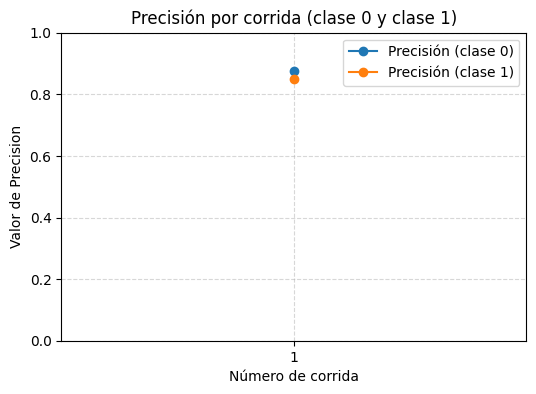

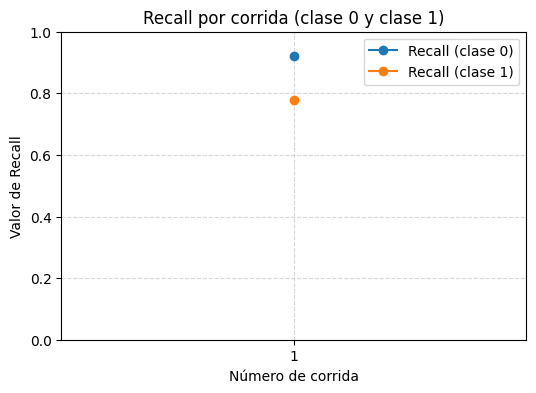

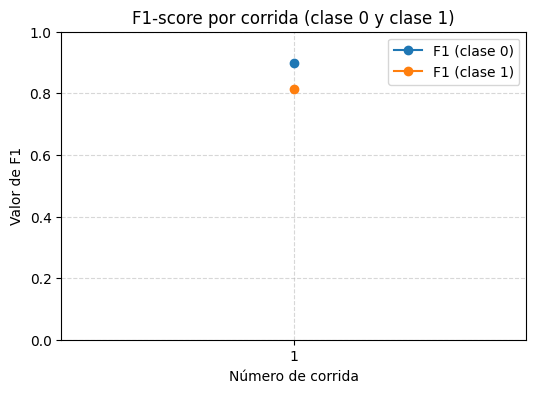

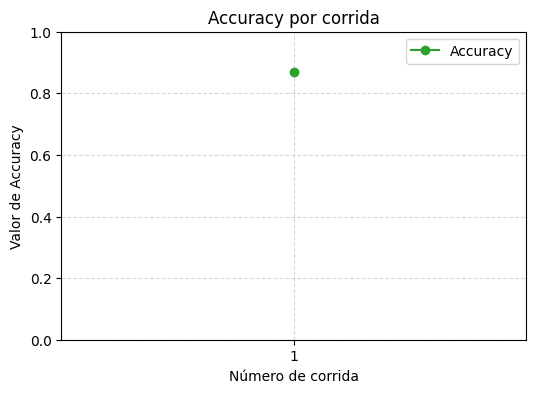

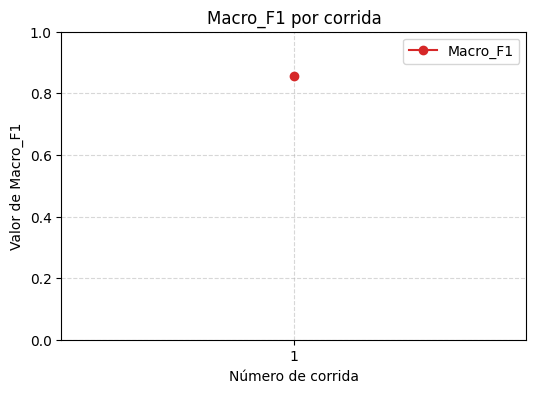

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df_results["run"] = df_results["seed"].map({s: i for i, s in enumerate(seeds, start=1)})

# --------------------------------------------------------
# 1) Supongamos que ya tienes tu DataFrame `df_resultados_long`

df = df_results

# --------------------------------------------------------
# 2) Definimos los estilos básicos de los gráficos
# --------------------------------------------------------
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["lines.marker"]   = 'o'
plt.rcParams["lines.linestyle"] = '-'
plt.rcParams["axes.grid"]      = True
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["grid.alpha"]     = 0.5

# Estas dos listas las usamos para “sacar” los valores de cada corrida:
runs = sorted(df["run"].unique())

# Colores fijos (uno para cada clase)
color_clase = {0: "#1f77b4", 1: "#ff7f0e"}

# --------------------------------------------------------
# 3) Gráfico de PRECISIÓN (ambas clases en el mismo plot)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    # Tomamos sólo las filas de esa clase, ordenadas por corrida
    subset = df[df["clase"] == clase].sort_values("run")
    valores = subset["precision"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Precisión (clase {clase})")

plt.title("Precisión por corrida (clase 0 y clase 1)")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Precision")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()


# --------------------------------------------------------
# 4) Gráfico de RECALL (ambas clases en el mismo plot)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run")
    valores = subset["recall"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Recall (clase {clase})")

plt.title("Recall por corrida (clase 0 y clase 1)")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Recall")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()


# --------------------------------------------------------
# 5) Gráfico de F1-SCORE (ambas clases en el mismo plot)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run")
    valores = subset["f1"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"F1 (clase {clase})")

plt.title("F1-score por corrida (clase 0 y clase 1)")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()


# --------------------------------------------------------
# 7) Gráficos de métricas globales (una sola línea con un valor por corrida)
# --------------------------------------------------------
# 7.1) ACCURACY
plt.figure()
acc_por_run = df.groupby("run")["accuracy"].first().reset_index()
plt.plot(acc_por_run["run"], acc_por_run["accuracy"], color="#2ca02c", label="Accuracy")
plt.title("Accuracy por corrida")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Accuracy")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()

# 7.2) MACRO_F1
plt.figure()
macro_por_run = df.groupby("run")["macro_f1"].first().reset_index()
plt.plot(macro_por_run["run"], macro_por_run["macro_f1"], color="#d62728", label="Macro_F1")
plt.title("Macro_F1 por corrida")
plt.xlabel("Número de corrida")
plt.ylabel("Valor de Macro_F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.show()


Se obtienen los mismo resultados al ejecutar con el mismo k porque KNN es determinista.

1. Qué tanto perdí cuando lo hice con knn on embeddings vs resnet. Calcular todas las métricas. Guardar csv en el bucket.
